In [1]:
import wisps
import numpy as np
import matplotlib.pyplot as plt
import wisps.simulations as wispsim
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from matplotlib.colors import Normalize
import astropy.units as u 
import wisps.simulations.effective_numbers as eff
import seaborn as sns
import matplotlib
import itertools
#plt.style.use('dark_background')


%matplotlib inline

Adding 2404 sources from /Users/caganze/research/splat//resources/Spectra/Public/SPEX-PRISM/ to spectral database
Adding 89 sources from /Users/caganze/research/splat//resources/Spectra/Public/MAGE/ to spectral database
Adding 145 sources from /Users/caganze/research/splat//resources/Spectra/Public/LRIS-RED/ to spectral database












In [2]:
sgrid=wispsim.SPGRID
pnts=pd.read_pickle(wisps.OUTPUT_FILES+'/pointings_correctedf110.pkl')
corr_pols=wisps.POLYNOMIAL_RELATIONS['mag_limit_corrections'] 
klf=pd.read_csv('/users/caganze/research/wisps/data/kirkpatricklf.txt', delimiter=',')
klf['bin_center']=np.mean(np.array([klf.t0.values, klf.tf.values]), axis=0)
klf=klf.replace(0.0,np.nan)

cands=pd.read_pickle(wisps.LIBRARIES+'/real_ucds.pkl')
cands=cands[(cands.spt >=17) & (cands.snr1>=3)].reset_index(drop=True)
tab=wisps.Annotator.reformat_table(cands)
pnt_names=[x.name for x in pnts]

In [3]:
#cmap= sns.color_palette("coolwarm", 8, as_cmap=True)
cmap=matplotlib.cm.get_cmap('coolwarm')
cnorm=Normalize(wispsim.HS[0]/100, (wispsim.HS[-1])/100)

In [4]:
kirkpatrick2020LF={'bin_center':np.flip(np.array([2025, 1875, 1725, 1575, 1425, 1275, 1125 , 975, 825, 675, 525])), 
                   'values':np.flip(np.array([0.72, 0.50,0.78, 0.81,0.94, 1.95, 1.11, 1.72, 1.99, 2.80, 4.24])), 
                   'unc':np.flip(([0.18, 0.17, 0.20,0.20, 0.22, 0.3, 0.25, 0.3, 0.32, 0.37, 0.70]))}


In [5]:
def bin_by_spt_bin(sp_types, number, ltonly=False):
    ranges=[[17, 20], [20, 25], [25, 30], [30, 35], [35, 40]]
    if ltonly:
        ranges=[[17, 20], [20, 30], [30, 41]]
    numbers=[]
    for r in ranges:
        idx= np.logical_and((r[0]<=sp_types), (r[1]>sp_types))
        numbers.append(np.nansum(number[idx]))
    return numbers

def get_all_numbers():
    #Distribute the parameter sets evenly across the cores
    func=lambda x, y:  get_simulated_number_model(y, x)

    paramlist=[(i, j)  for i, j in itertools.product(['saumon2008', 'baraffe2003', 'marley2019', 'phillips2020'], wispsim.HS)]
    res  = [func(x, y) for x,y in tqdm(paramlist)]
    
    nbrs = {}
    for k in ['saumon2008', 'marley2019', 'phillips2020', 'baraffe2003']:
        ds0={}
        for j in res:
            if k in j.keys():
                key=[x for x in j[k].keys()][0]
                ds0.update({key: [(j[k][key])[yi] for yi in wispsim.SPGRID]})
        #print (ds0)
        nbrs[k]=np.array([ds0[k] for k in wispsim.HS])

    return nbrs
    


def get_pointing(grism_id):
    if grism_id.startswith('par'):
        pntname=grism_id.lower().split('-')[0]
    else:
        pntname=grism_id.lower().split('-g141')[0]
    loc=pnt_names.index(pntname)
    return np.array(pnts)[loc]


def iswithin_mag_limits(mags, pnt, spt):
    #mgs is a dictionary
    flags=[]
    for k in pnt.mag_limits.keys():
        if k =='F110' and pnt.survey =='hst3d':
            flags.append(True)
        else:
            flags.append(mags[k] <= pnt.mag_limits[k]+ (corr_pols['F110W'][0]+1.5)(spt))
    return np.logical_or.reduce(flags)

def scale_lf_teff(teffs):
    binedges= np.append(kirkpatrick2020LF['bin_center']-75, kirkpatrick2020LF['bin_center'][-1]-75)
    bools=np.logical_and(teffs <= binedges[-1], teffs >= binedges[0])
    preds=np.histogram(teffs, bins=binedges, normed=False)[0]
    
    obs=np.array(kirkpatrick2020LF['values'])
    unc=np.array(kirkpatrick2020LF['unc'])
    
    obs_monte_carlo= np.random.normal(obs, unc, (10000, len(obs)))
    pred_monte= np.ones_like(obs_monte_carlo)*(preds)
    unc_monte=  np.ones_like(obs_monte_carlo)*(unc)
    
    
    
    #unc_monte= 
    scale=(np.nansum((obs_monte_carlo*pred_monte)/(unc_monte**2), axis=1)\
           /np.nansum(((pred_monte**2)/(unc_monte**2)), axis=1))*(10**-3)
    
    
    
    #fig, ax=plt.subplots()
    #ax.step(kirkpatrick2020LF['bin_centertw'], preds*scale*(10**-3), where='mid')
    #ax.errorbar(kirkpatrick2020LF['bin_center'], np.array(kirkpatrick2020LF['values'])*(10**-3),
    #         yerr= np.array(kirkpatrick2020LF['unc'])*(10**-3), fmt='o', color='#111111')
    return [np.nanmean(scale), np.nanstd(scale), len(teffs)]
def get_simulated_number_model(hidx, model):
    #hidx is a scale height, model is evolutionary model
    cutdf=pd.read_hdf(wisps.OUTPUT_FILES+'/final_simulated_sample_cut.h5', key=str(model)+str('h')+str(hidx)+'F110_corrected')
    scl_dict=pd.read_pickle(wisps.OUTPUT_FILES+'/lf_scales.pkl') 
    scale=scl_dict[model]
    #scale=scale_lf_teff(cutdf.teff)
    NSIM=dict(zip(wispsim.SPGRID,np.zeros((len(wispsim.SPGRID), 2))))
    cutdf['spt_r']=cutdf.spt.apply(np.round)
    for g in cutdf.groupby('spt_r'):
        sn= len(cutdf.teff[np.logical_and(cutdf.teff>=450, cutdf.teff<=1950)])
        scln=np.array([scale[-1]/sn, (scale[1]*scale[-1])/(sn*scale[0])])
        #scln=np.array(scale)
        #assert scln[0] > scale[0]
        NSIM[g[0]]=np.nansum(g[1].sl)*scln
    del cutdf
    return {model: {hidx:NSIM}}


def plot(NUMBERS, VOLUMES, filename='/oberved_numbers.pdf'):
    # In[ ]:
    nall=wisps.custom_histogram(cands.spt.apply(wisps.make_spt_number), sgrid, 1)
    
    y2=bin_by_spt_bin(wispsim.SPGRID,nobs, ltonly=False)
    yall=bin_by_spt_bin(wispsim.SPGRID,nall, ltonly=False)
    
    dy2=np.sqrt(y2)
    dyall=np.sqrt(yall)

    fig, ax=plt.subplots(figsize=(12, 12), ncols=2, nrows=2, sharey=False, sharex=False)
    
    for model, a in zip(['baraffe2003', 'saumon2008', 'marley2019', 'phillips2020'], np.concatenate(ax)):
        
        for idx, h in enumerate(wispsim.HS):
            
            ns=None
            ns=((NUMBERS[model])[idx])[:,0]*VOLUMES[idx]
            nuncs=((NUMBERS[model])[idx])[:,1]*VOLUMES[idx]
            
            a.plot(spgrid2, bin_by_spt_bin(wispsim.SPGRID,ns, ltonly=False), 
                          label='h={} pc'.format(h), color= cmap(cnorm(h/100)), 
                   linewidth=3, drawstyle="steps-mid")
            a.fill_between(spgrid2, bin_by_spt_bin(wispsim.SPGRID,ns+nuncs, ltonly=False),  
                           bin_by_spt_bin(wispsim.SPGRID,ns-nuncs, ltonly=False), alpha=0.5, 
                           color= cmap(cnorm(h/100)),  step="mid")
        
        a.set_yscale('log')
        a.errorbar(spgrid2,y2, yerr=dy2,fmt='o', color='#111111')
        a.errorbar(spgrid2,yall, yerr=dyall,color='#B10DC9', fmt='o')
        a.set_xlabel('SpT',fontsize=18)
        a.set_ylabel('N',fontsize=18)
        a.minorticks_on()
            


    ax[0][1].set_title('Model= SM08', fontsize=18)
    ax[0][0].set_title('Model= B03', fontsize=18)
    ax[1][0].set_title('Model= M19', fontsize=18)
    ax[1][1].set_title('Model= P20', fontsize=18)

    ax[0][0].errorbar(spgrid2,y2, yerr=dy2,fmt='o', label='observations', color='#111111')
    ax[0][0].errorbar(spgrid2,yall, yerr=dyall,color='#B10DC9', fmt='o', label='All observations')
    
    ax[0][0].legend(fontsize=14, loc='upper right')
    plt.tight_layout()
    plt.savefig(wisps.OUTPUT_FIGURES+filename, bbox_inches='tight')

In [6]:
#get_simulated_number_model(350, 'saumon2008')

In [7]:
#d=pd.read_pickle(wisps.OUTPUT_FILES+'/distance_samples{}'.format(h))

In [8]:
#np.shape(d[17])

In [9]:
tab['pnt']=tab['grism_id'].apply(get_pointing)
tab['spt_val']=np.vstack(tab.spt.values)[:,0]
obsmgs=tab[['F140W', 'F110W', 'F160W']].rename(columns={"F110W": "F110", 
                                                                    "F140W": "F140",
                                                                    "F160W": "F160"}).to_dict('records')

flags=[iswithin_mag_limits(x, y, z) for x, y, z in zip(obsmgs, tab.pnt.values,tab.spt.values )]

#let's see what happens if we include all objects
#flags=np.ones(len(flags)).astype(bool)
cdf_to_use=tab[flags]

nobs=wisps.custom_histogram(cdf_to_use.spt_val.apply(wisps.make_spt_number), sgrid, 1)

spgrid2=['M7-L0', 'L0-L5', 'L5-T0', 'T0-T5', 'T5-Y0']
spgrid3=['Late M', 'L', 'T']

In [10]:
for k in ['F140', 'F110', 'F160']:
    tab['lim_{}'.format(k)]=tab.pnt.apply(lambda x: x.mag_limits[k])
    tab['detected_{}'.format(k)]= tab[k+'W'] < tab['lim_{}'.format(k)]

In [11]:
subtab=(tab[tab.spt.between(30, 35)]).reset_index(drop=True)

In [12]:
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    print( subtab[['F140W', 'F160W', 'lim_F140', 'lim_F160', 'detected_F140', 'detected_F160', 'grism_id',
#                  'spt']])

In [13]:
#NUMBERS=pd.read_pickle(wisps.OUTPUT_FILES+'/numbers_simulated.pkl')
NUMBERS=get_all_numbers()

100%|██████████| 44/44 [00:47<00:00,  1.08s/it]


In [14]:
#plt.hist(np.log10(NUMBERS['baraffe2003'][0][:,1]))

In [15]:
volumes=[]
for pnt in pnts:
    vs=[]
    for h in wispsim.HS:
        vsx=[]
        for g in wispsim.SPGRID:
            vsx.append((pnt.volumes[h])[g])
        vs.append(vsx)
    volumes.append(vs)
volumes=np.array(volumes)

VOLUMES=(np.nansum(volumes, axis=0))*4.1*(u.arcmin**2).to(u.radian**2)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


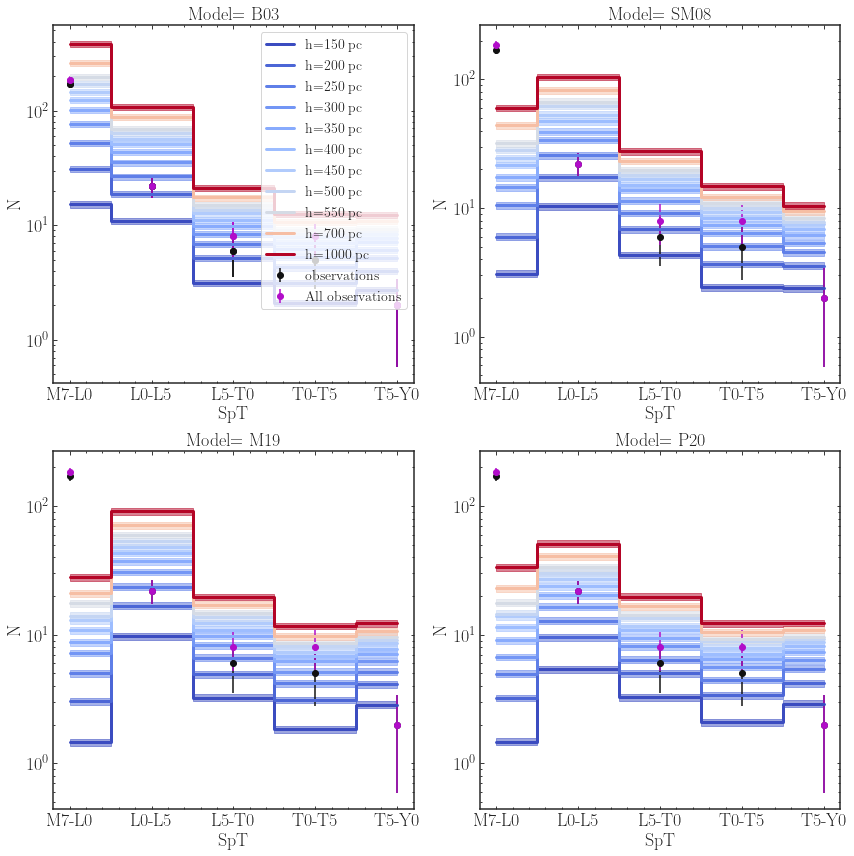

In [16]:
 plot(NUMBERS, VOLUMES, filename='/obs_numbers.pdf')

In [17]:
nall=wisps.custom_histogram(cands.spt.apply(wisps.make_spt_number), sgrid, 1)
y2=bin_by_spt_bin(wispsim.SPGRID,nobs, ltonly=False)

In [18]:
#cands[cands.spt.between(30, 35)].F140W,cands[cands.spt.between(30, 35)].F160W, 

In [19]:
#bin_by_spt_bin(wispsim.SPGRID,nall, ltonly=False)

In [20]:
#just for L dwarfs and T dwarfs
y3=bin_by_spt_bin(wispsim.SPGRID,nall, ltonly=False)

In [21]:
y3

[185, 22, 8, 8, 2]

In [22]:
y2

[170, 22, 6, 5, 2]

In [23]:
y4=np.append(y2, y3)

In [24]:
#PRINT THE BEST FIT NUMBER 
#best_fit={}
numbers_fit={}
for model in ['saumon2008', 'baraffe2003', 'marley2019', 'phillips2020']:
        model_fit={}
        model_number={}
        for idx, h in enumerate(wispsim.HS):
            
            ns=None
            ns=((NUMBERS[model])[idx])[:,0]*VOLUMES[idx]
            nuncs=((NUMBERS[model])[idx])[:,1]*VOLUMES[idx]
            
            binned=np.array(bin_by_spt_bin(wispsim.SPGRID,ns, ltonly=False))
            binned_unc=np.array(bin_by_spt_bin(wispsim.SPGRID,nuncs, ltonly=False))
            #add L and 
            #compute chi-squared
            #print (ns)
            #chisq= abs((y2-binned)**2/(y2))
            #model_fit.update({h: chisq})
            #binned_total=np.append(binned, binned_lt)
            #binned_total=np.append(binned, binned_lt)
            model_number.update({h: binned})
        # best_fit.update({model: model_fit})
        numbers_fit.update({model: model_number})

In [25]:
#chisq_dicts=pd.DataFrame.from_records(best_fit)
number_dicts=pd.DataFrame.from_records(numbers_fit)

In [26]:
from scipy.interpolate import interp1d

In [27]:
len(tab[tab.spt.between(30, 35)])

8

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


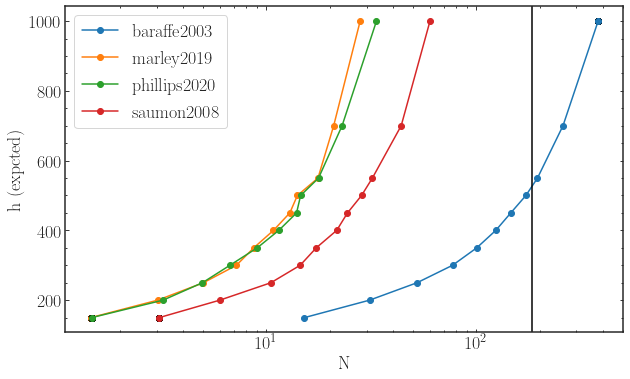

In [28]:
fig, ax=plt.subplots(figsize=(10, 6))
idx=0
for c in number_dicts.columns:
    
    vals=np.vstack([number_dicts[c][h] for h in wispsim.HS])[:,idx]

    interpf = interp1d(vals, wispsim.HS)
    npoisson=np.random.poisson(y2[idx], 100000).astype(float)
    #assign up and down 
    dflag=npoisson>=vals.min()
    uflag= npoisson <=vals.max()
    npoisson[dflag]= vals.min()
    npoisson[uflag]= vals.max()
    predhs=interpf(npoisson)
    sortarray=np.argsort(npoisson)
    plt.plot(  (npoisson)[sortarray], predhs[sortarray],'o-', c='k', alpha=0.1)
    plt.plot(vals, wispsim.HS, 'o-', label=c)
plt.ylabel('h (expcted)', fontsize=18)
plt.xlabel('N', fontsize=18)
plt.xscale('log')
plt.axvline(y3[idx], c='k')
plt.legend()
plt.minorticks_on()

In [29]:
wispsim.HS

[150, 200, 250, 300, 350, 400, 450, 500, 550, 700, 1000]

In [30]:
#number_dicts['marley2019'][500]

In [31]:
min_chi_ssqrs={}
for c in number_dicts.columns:
    min_vals={}
    #for idx,s  in enumerate(np.append(spgrid2, ['L dwarfs', 'T dwarfs'])):
    for idx,s  in enumerate(spgrid2):
        #compare between subtypes
        #predicted
        vals=(np.vstack(number_dicts[c].values))[:,idx]
        #observed
        nreal= y3[idx]
        #make an interpolation function
        interpf = interp1d(vals, wispsim.HS)
        #using a 2nd degree polynomial 
        
        #draw a bunch of random values based on a poisson distribution
        npoisson=np.random.poisson(nreal, 100000).astype(float)
        #stay within the range of possible values to avoid interpolation error
        #i.e take this as a prior
        #dflag=npoisson>=vals.min()
        #uflag= npoisson <=vals.max()
        #npoisson[dflag]= vals.min()
        #npoisson[uflag]= vals.max()
        npoisson=npoisson[np.logical_and(npoisson>=vals.min(), npoisson <=vals.max())]
        #predict scale heights
        predhs=interpf(npoisson)
        #use a weighted mean and std 
        mean, unc= (np.nanmean(predhs), np.nanstd(predhs))
    
        
        min_vals.update({s:[np.round(mean), np.round(unc, 4)]})
        #final minimal
        print (' scale height for model {} and spt {} is {} +/- {} '.format(c, s, np.round(mean), np.round(unc, 4)))
        
    min_chi_ssqrs.update({c:min_vals})
    

 scale height for model baraffe2003 and spt M7-L0 is 528.0 +/- 29.4006 
 scale height for model baraffe2003 and spt L0-L5 is 220.0 +/- 29.1844 
 scale height for model baraffe2003 and spt L5-T0 is 301.0 +/- 91.9388 
 scale height for model baraffe2003 and spt T0-T5 is 472.0 +/- 178.9521 
 scale height for model baraffe2003 and spt T5-Y0 is 189.0 +/- 41.45 
 scale height for model marley2019 and spt M7-L0 is nan +/- nan 
 scale height for model marley2019 and spt L0-L5 is 238.0 +/- 33.6414 
 scale height for model marley2019 and spt L5-T0 is 306.0 +/- 92.7255 
 scale height for model marley2019 and spt T0-T5 is 485.0 +/- 196.8277 
 scale height for model marley2019 and spt T5-Y0 is 184.0 +/- 41.6925 
 scale height for model phillips2020 and spt M7-L0 is nan +/- nan 
 scale height for model phillips2020 and spt L0-L5 is 376.0 +/- 67.5867 
 scale height for model phillips2020 and spt L5-T0 is 313.0 +/- 97.91 
 scale height for model phillips2020 and spt T0-T5 is 470.0 +/- 195.3069 
 scale

In [32]:
def propagate_uncertainties(row):
    vals=np.vstack(row.values)[:, 0]
    uncs=np.vstack(row.values)[:,1]
    
    return round(np.nanmean(vals)), round(np.sqrt(np.nansum(uncs**2)+ np.nanstd(vals)**2))

In [33]:
min_chi_ssqrs_df=pd.DataFrame(min_chi_ssqrs)

In [34]:
#don't use certain models for certain types
min_chi_ssqrs_df.phillips2020['M7-L0']=[np.nan, np.nan]
min_chi_ssqrs_df.marley2019['M7-L0']=[np.nan, np.nan]
min_chi_ssqrs_df.saumon2008['M7-L0']=[np.nan, np.nan]

In [35]:
min_chi_ssqrs_df.applymap(lambda x: np.round(x))

,baraffe2003,marley2019,phillips2020,saumon2008
M7-L0,"[528.0, 29.0]","[nan, nan]","[nan, nan]","[nan, nan]"
L0-L5,"[220.0, 29.0]","[238.0, 34.0]","[376.0, 68.0]","[228.0, 29.0]"
L5-T0,"[301.0, 92.0]","[306.0, 93.0]","[313.0, 98.0]","[237.0, 55.0]"
T0-T5,"[472.0, 179.0]","[485.0, 197.0]","[470.0, 195.0]","[402.0, 156.0]"
T5-Y0,"[189.0, 41.0]","[184.0, 42.0]","[181.0, 40.0]","[210.0, 52.0]"


In [36]:
#min_chi_ssqrs_df.apply(propagate_uncertainties, axis=1)

In [37]:
#use my velocity dispersion converter 
def velocity_dispersion(h, hunc):
    #do a monte carlo uncertainty prop
    hs= np.random.normal(h, hunc, 10000)
    vals=np.sqrt((hs*68)/435*20)
    return np.nanmean(vals), np.nanstd(vals)

vel_tables=min_chi_ssqrs_df.applymap(lambda x: velocity_dispersion(x[0], x[1]))

In [38]:
vel_tables

,baraffe2003,marley2019,phillips2020,saumon2008
M7-L0,"(40.62202474184244, 1.12673605637249)","(nan, nan)","(nan, nan)","(nan, nan)"
L0-L5,"(26.16778415764781, 1.7633666197189046)","(27.24804649448123, 1.9455856424922564)","(34.10107813438859, 3.1364285206155023)","(26.670826322246192, 1.7004285243532835)"
L5-T0,"(30.382826503899594, 4.915778936396106)","(30.4689942349008, 4.877388705872119)","(30.904865708027106, 5.121269560559992)","(27.051873879950623, 3.227001776475658)"
T0-T5,"(37.68670331017972, 7.6928579037988225)","(38.20411045575098, 8.321731291284376)","(37.64356506398076, 8.25911449222538)","(34.85527580207122, 7.149188431682239)"
T5-Y0,"(24.174265033278864, 2.729620612911744)","(23.801941748328503, 2.8022960072539065)","(23.67596762667686, 2.660428689690801)","(25.428461546986224, 3.237789657338217)"


In [39]:
#do monte carlo uncertainty propagation
def get_age(sigma, sigmaunc, beta, tau1, sigma10):
    sigmas=np.random.normal(sigma, sigmaunc, 10000)
    vals=((sigmas/sigma10)**(1/beta))*(10+tau1)-tau1
    return np.nanmean(vals), np.nanstd(vals)

In [40]:
age_tables= vel_tables.applymap(lambda x: get_age(x[0], x[1], 0.385, 0.261, 57.157))
#age_tables=age_tables.applymap(lambda x:np.array(x)).apply(lambda x: np.round(x, 1))

In [41]:
age_tables

,baraffe2003,marley2019,phillips2020,saumon2008
M7-L0,"(3.9713797516218126, 0.3023109663365515)","(nan, nan)","(nan, nan)","(nan, nan)"
L0-L5,"(1.1029980872021037, 0.235432301649957)","(1.2548347178616797, 0.28458009807477325)","(2.47387742157427, 0.6462052548579719)","(1.1684741148591316, 0.23402640151692763)"
L5-T0,"(1.828864851191274, 0.8580333754856748)","(1.8443332002079202, 0.8551871457712003)","(1.937759660248958, 0.9153407609959867)","(1.2556858219917588, 0.4630534299627846)"
T0-T5,"(3.509504009761964, 1.9173390700502178)","(3.6620723692848207, 2.141586077365354)","(3.5270297140833065, 2.031892285585)","(2.8374164932261103, 1.5715291239092286)"
T5-Y0,"(0.8613795212665789, 0.3273698752783605)","(0.8237809712743234, 0.32721792611954237)","(0.8147687553265174, 0.3107213429105833)","(1.0350208322607513, 0.42295321052446233)"


In [42]:
#age_emp=pd.DataFrame()
#age_emp['subtype']=np.array(age_tables.index)
#age_emp['age']=np.vstack(age_tables.values)[:,0]
#age_emp['unc']=np.vstack(age_tables.values)[:,1]

In [43]:
#age_tables.apply(propagate_uncertainties, axis=1)

In [44]:
#upper and lo limits on ages 
up_lims_table=pd.DataFrame(columns= age_tables.columns,
                           index=age_tables.index).fillna(0)
up_lims_table.saumon2008['T0-T5']=1
up_lims_table.saumon2008['T0-T5']=1

#lo limts
lo_lims_table=pd.DataFrame(columns= age_tables.columns,
                           index=age_tables.index).fillna(0)
lo_lims_table.baraffe2003['T5-Y0']=1
lo_lims_table.baraffe2003['L5-T0']=1
lo_lims_table.phillips2020['T5-Y0']=1
lo_lims_table.saumon2008['T5-Y0']=1
lo_lims_table.marley2019['T5-Y0']=1


In [45]:
lo_lims_table

,baraffe2003,marley2019,phillips2020,saumon2008
M7-L0,0,0,0,0
L0-L5,0,0,0,0
L5-T0,1,0,0,0
T0-T5,0,0,0,0
T5-Y0,1,1,1,1


In [46]:
def get_simpler_class(x):
    if x.startswith('M'):
        return 'Late M'
    if x.startswith('L'):
        return 'L'
    if x.startswith('T'):
        return 'T'

In [47]:
#plot age with scale heights
age_dictionaries={}
for model in ['saumon2008', 'baraffe2003', 'marley2019', 'phillips2020']:
    dfs=[]
    for hidx in wispsim.HS:
        dfs.append(pd.read_hdf(wisps.OUTPUT_FILES+'/final_simulated_sample_cut.h5',
                               key=str(model)+str('h')+str(hidx)+'F110_corrected'))
        
    df=pd.concat(dfs)
    print (len(df))
    cutdf_lblded=wisps.Annotator.group_by_spt(df, spt_label='spt', assign_number=False).rename(columns={'spt_range': 'subtype'})
    cutdf_lblded['spectclass']=  cutdf_lblded.subtype.apply(get_simpler_class)
    final_df=cutdf_lblded[~((cutdf_lblded.spectclass=='') | (cutdf_lblded.subtype=='')|   (cutdf_lblded.subtype=='trash'))]
    age_dictionaries[model]=final_df

215768
233242
219076
212513


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


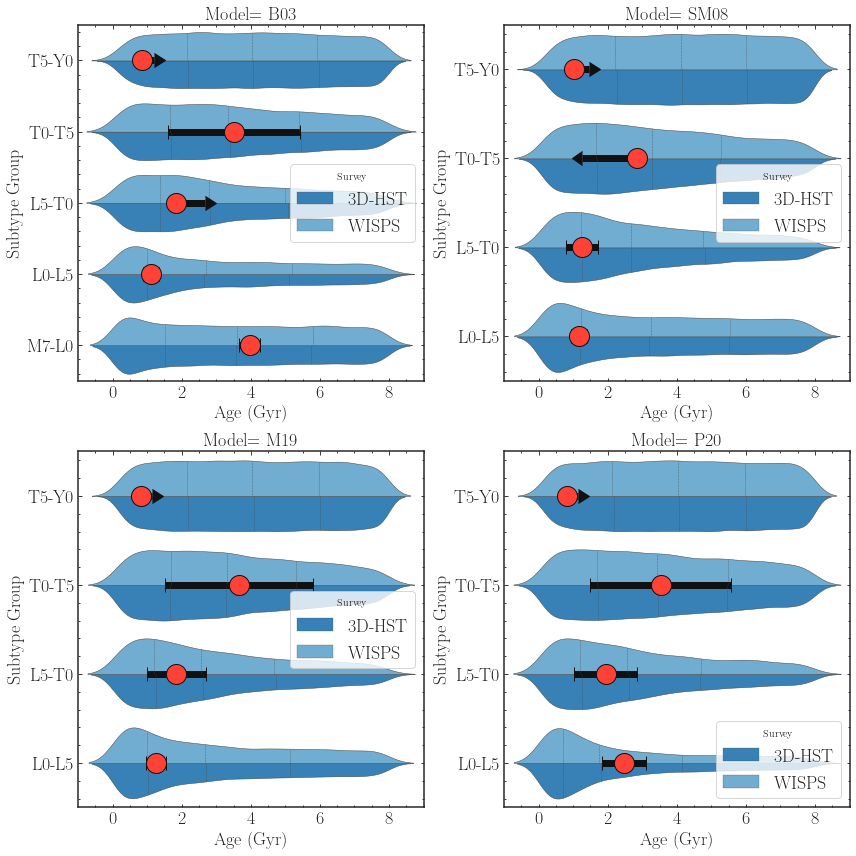

In [48]:

fig, ax=plt.subplots(figsize=(12, 12), ncols=2, nrows=2, sharex=False, sharey=False)

for model, a in zip([ 'baraffe2003', 'saumon2008','marley2019', 'phillips2020'], np.concatenate(ax)):
    dfn=age_dictionaries[model].replace('T5-T9', 'T5-Y0')
    dfn['Survey']=dfn.pnt.apply(lambda x: x.survey)
    dfn.Survey=dfn.Survey.replace('hst3d', '3d-hst'.upper())
    dfn.Survey=dfn.Survey.replace('wisps', 'wisps'.upper())
    age_emp=pd.DataFrame()
    age_emp['subtype']=np.array(age_tables[model].index)
    age_emp['age']=np.vstack(age_tables[model].values)[:,0]
    age_emp['unc']=np.vstack(age_tables[model].values)[:,1]
    age_emp.unc[age_emp.unc<0.1]=1
    agfn= age_emp
    #lower limits
    lolims=lo_lims_table[model].values.astype(bool)
    #upper limits
    uplims =up_lims_table[model].values.astype(bool)
    if model !='baraffe2003':
        dfn=dfn[dfn.subtype != 'M7-L0']
        agfn=agfn[agfn.subtype !='M7-L0']
        lolims=lo_lims_table[model].values.astype(bool)[1:]
        uplims =up_lims_table[model].values.astype(bool)[1:]

        sns.violinplot(x='age', y='subtype', data=dfn, ax=a,
                    palette="tab20c", hue='Survey', saturation=0.9, scale='area',
                       order=['L0-L5', 'L5-T0', 'T0-T5', 'T5-Y0'], 
                       split=True, linewidth=0.5, inner="quartile")
        a.set_ylim([-0.5, 3.5])
    else:
        sns.violinplot(x='age', y='subtype', data=dfn, ax=a,
                    palette="tab20c", hue='Survey', saturation=0.9, scale='area', 
                       order=spgrid2, split=True, linewidth=0.5, inner="quartile")
        a.set_ylim([-0.5, 4.5])
        
    
    #sns.boxplot(y=dfn.age.values*dfn.slprob, x=dfn.spectclass, ax=a,
    #            color='#FF851B')
    
    #upper and low limit of the error
    #print (lolims =
    a.errorbar(  agfn.age, agfn.subtype, xerr=agfn.unc,  fmt='o',xlolims=lolims, ms=20, lw=7, capsize=7, 
               mfc='#FF4136', mec='#111111', ecolor='#111111', xuplims=uplims)
    #a.set_xlim()
    a.set_ylabel('Subtype Group', fontsize=18)
    a.set_xlabel('Age (Gyr)', fontsize=18)
    a.set_xlim([-1, 9.])
    a.minorticks_on()

ax[0][0].set_title('Model= B03', fontsize=18)
ax[0][1].set_title('Model= SM08', fontsize=18)
ax[1][0].set_title('Model= M19', fontsize=18)
ax[1][1].set_title('Model= P20', fontsize=18)

plt.tight_layout()


plt.savefig(wisps.OUTPUT_FIGURES+'/age_comparison.pdf', bbox_inches='tight')


In [49]:
i=pd.read_pickle(wisps.OUTPUT_FILES+'/polynomial_relations.pkl.gz')